# Multi-Agent Deep AI Finance Researcher from Scratch

Hierarchical multi-agent system with Orchestrator, Researcher, and Editor agents for deep financial research.

## Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from dotenv import load_dotenv
load_dotenv()

from typing import Annotated
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver
from scripts.rag_tools import hybrid_search, live_finance_researcher

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.agents import create_agent
from langchain.messages import HumanMessage, AIMessage, ToolMessage

In [3]:
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt import InjectedState
from langgraph.types import Command

from scripts.file_tools import (
    DeepAgentState,
    ls,
    read_file,
    write_file,
    cleanup_files,
    generate_hash,
    _disk_path
)

from scripts.prompts import (
    ORCHESTRATOR_PROMPT,
    RESEARCHER_PROMPT,
    EDITOR_PROMPT,
)

## Initialize Components and Create Worker Agents

In [4]:
# llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash', temperature=0.7)/
llm = ChatGoogleGenerativeAI(model='gemini-3-flash-preview')

conn = sqlite3.connect("data/deep_finance_researcher.db", check_same_thread=False)
checkpointer = SqliteSaver(conn=conn)

In [5]:
# Researcher Agent - uses RAG and live finance tools
researcher_agent = create_agent(
    model=llm,
    tools=[ls, write_file, read_file, hybrid_search, live_finance_researcher],
    system_prompt=RESEARCHER_PROMPT,
    state_schema=DeepAgentState,
)

# Editor Agent
editor_agent = create_agent(
    model=llm,
    tools=[ls, read_file, write_file, cleanup_files],
    system_prompt=EDITOR_PROMPT,
    state_schema=DeepAgentState,
)

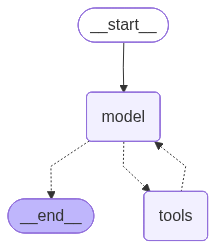

In [6]:
researcher_agent

## Define Orchestrator Tools

In [7]:
@tool
def write_research_plan(
    thematic_questions: list[str],
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
):
    """
    Write the high-level research plan with major thematic questions.

    Args:
        thematic_questions: List of 3-5 major thematic questions
        state: Injected agent state
        tool_call_id: Tool call ID

    Returns:
        Command with ToolMessage confirming the plan was written
    """
    content = "# Research Plan\n\n"

    content = content + "## User Query\n"
    content = content + state["messages"][-1].text + "\n\n"

    content = content + "## Thematic Questions\n\n"
    for i, question in enumerate(thematic_questions, 1):
        content = content + f"{i}. {question}\n"

    path = _disk_path(state, "research_plan.md")
    with open(path, "w", encoding="utf-8") as f:
        f.write(content)

    msg = f"[RESEARCH PLAN WRITTEN] research_plan.md with {len(thematic_questions)} thematic questions"
    return Command(update={"messages": [ToolMessage(msg, tool_call_id=tool_call_id)]})



In [8]:
@tool
def run_researcher(
            theme_id: int,
            thematic_question: str,
            state: Annotated[DeepAgentState, InjectedState],
            max_retries: int = 2
        ):
    """
    Run a single Research agent for ONE thematic question.

    Args:
        theme_id: The theme number (1, 2, 3, etc.)
        thematic_question: The specific thematic question to research
        state: Injected agent state
        max_retries: Number of retry attempts

    Returns:
        Status string for the orchestrator
    """
    
    file_hash = generate_hash(f"{theme_id}_{thematic_question}")

    ai_message_instruction = f"""[THEME {theme_id}] {thematic_question}

                        Save research to: researcher/{file_hash}_theme.md
                        Save sources to: researcher/{file_hash}_sources.txt
                        """

    sub_state: DeepAgentState = {
        "messages": state["messages"] + [AIMessage(ai_message_instruction)],
        "user_id": state.get("user_id"),
        "thread_id": state.get("thread_id"),
    }

    for attempt in range(max_retries + 1):
        try:
            researcher_agent.invoke(sub_state)
            return f"✓ Theme {theme_id} research completed (hash: {file_hash})"
        except Exception:
            print(f"Failed. Trying #{attempt} times")

    return f"✗ Theme {theme_id} failed after {max_retries + 1} attempts"


In [9]:
@tool
def run_editor(state: Annotated[DeepAgentState, InjectedState]) -> str:
    """
    Run the Editor agent to synthesize all research into final report.

    Args:
        state: Injected agent state

    Returns:
        Status string
    """
    sub_state: DeepAgentState = {
        "messages": [HumanMessage(content="Read research_plan.md and all files in the researcher/ folder, then synthesize everything into a comprehensive report.md file.")],
        "user_id": state.get("user_id"),
        "thread_id": state.get("thread_id"),
    }
    editor_agent.invoke(sub_state)
    return "Editor completed. Final report is written to report.md."

## Create Orchestrator Agent

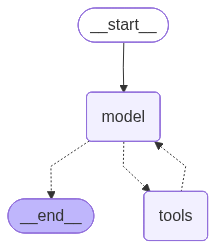

In [10]:
orchestrator_agent = create_agent(
    model=llm,
    tools=[write_research_plan, run_researcher, run_editor, cleanup_files],
    system_prompt=ORCHESTRATOR_PROMPT,
    state_schema=DeepAgentState,
    checkpointer=checkpointer
)

orchestrator_agent

## Examples

In [11]:
from scripts.agent_utils import stream_agent_response

# Simple question - direct answer
stream_agent_response(
    orchestrator_agent,
    "What is a 10-K report?",
    thread_id="thread_002",
    user_id="user_212",
)

A **10-K report** is a comprehensive annual document that all publicly traded companies in the United States are required by law to file with the **Securities and Exchange Commission (SEC)**. 

It provides a much more detailed picture of a company's financial health and business operations than a typical annual report sent to shareholders. 

### Key Components of a 10-K
A standard 10-K is divided into several parts, most notably:

1.  **Business Overview:** A description of the company’s main operations, products, services, and the markets in which it operates.
2.  **Risk Factors:** A disclosure of the specific risks the company faces, such as legal issues, market competition, or supply chain vulnerabilities.
3.  **Selected Financial Data:** Financial highlights covering the last five years.
4.  **Management’s Discussion and Analysis (MD&A):** Management’s explanation of the previous year’s financial results and their outlook for the future.
5.  **Financial Statements:** Audited versio

In [14]:
# Complex financial research
stream_agent_response(
    orchestrator_agent,
    "Do a detailed analysis of Amazon's financial performance in 2023 and 2024",
    thread_id="thread_003",
    user_id="user_212"
)


  Tool Called: write_research_plan
   Args: {'thematic_questions': ["Overview of Amazon's overall financial performance and revenue growth in 2023 and 2024.", 'Segment-level analysis: Performance of AWS, North America, and International segments in 2023 and 2024.', 'Profitability, operating margins, and net income trends for Amazon in 2023 and 2024.', 'Key growth drivers and strategic investments, specifically in AI, advertising, and logistics, during 2023-2024.', 'Future outlook, stock performance, and analyst expectations for Amazon heading into 2025.']}


  Tool Called: run_researcher
   Args: {'thematic_question': "Overview of Amazon's overall financial performance and revenue growth in 2023 and 2024.", 'theme_id': 1}


  Tool Called: run_researcher
   Args: {'thematic_question': 'Segment-level analysis: Performance of AWS, North America, and International segments in 2023 and 2024.', 'theme_id': 2}


  Tool Called: run_researcher
   Args: {'thematic_question': 'Profitability, ope

In [13]:
# response = editor_agent.invoke(
#     {'messages':[HumanMessage('write detailed report in report.md')],
#      'user_id':"user_212",
#     'thread_id':"thread_003"
#      }
# )